<a href="https://colab.research.google.com/github/subha100x/Guess-the-Number/blob/main/ClusteringReview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORT LIBRARIES

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

LOAD DATA, CHECK REQUIRED COLUMNS & DROP MISSING REVIEWS

In [19]:
print("Customer Review Clustering Analysis")
print("="*50)

df = pd.read_csv('amazon_reviews.csv')
print(f"Loaded {len(df)} rows from your CSV file")

review_column = 'Review Text'   # CHANGE IF YOUR COLUMN NAME IS DIFFERENT
rating_column = 'Rating'        # CHANGE IF YOUR COLUMN NAME IS DIFFERENT

reviews = df[review_column].dropna()
print(f"Processing {len(reviews)} valid reviews")


Customer Review Clustering Analysis
Loaded 4915 rows from your CSV file
Processing 4914 valid reviews


 TEXT PREPROCESSING

In [20]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    text = text.lower()                           # lowercase
    text = re.sub(r'[^a-z\s]', '', text)          # remove special chars & numbers
    words = text.split()
    words = [stemmer.stem(w) for w in words if w not in stop_words]  # remove stopwords & stem
    return ' '.join(words)

reviews_cleaned = reviews.apply(clean_text).drop_duplicates()
print(f"Cleaned text, final {len(reviews_cleaned)} unique reviews")



Cleaned text, final 4910 unique reviews


VISUALIZE RATINGS


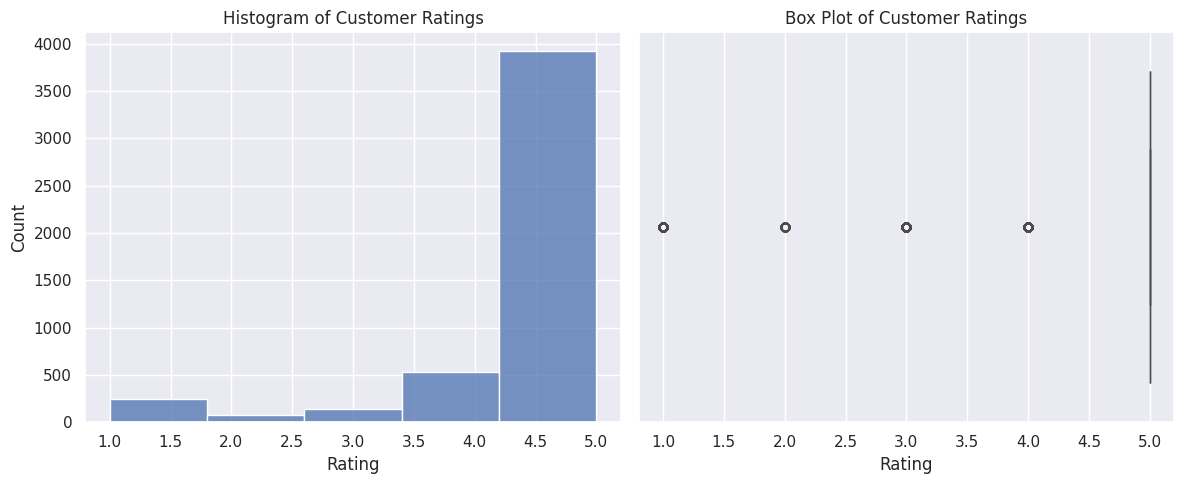

In [22]:
if rating_column in df.columns:
    plt.figure(figsize=(12,5))

    # Histogram
    plt.subplot(1,2,1)
    sns.histplot(df[rating_column].dropna(), bins=5, kde=False)
    plt.title("Histogram of Customer Ratings")
    plt.xlabel("Rating")
    plt.ylabel("Count")

    # Box Plot
    plt.subplot(1,2,2)
    sns.boxplot(x=df[rating_column].dropna())
    plt.title("Box Plot of Customer Ratings")
    plt.xlabel("Rating")

    plt.tight_layout()
    plt.show()
else:
    print("No rating column found in dataset, skipping rating visualization.")


CONVERT TEXT TO VECTORS

In [23]:
vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
X = vectorizer.fit_transform(reviews_cleaned)
print(f"Converted text to TF-IDF vectors: {X.shape}")

Converted text to TF-IDF vectors: (4910, 100)


CLUSTERING - KMEANS

In [24]:
print("\n TESTING K-MEANS...")
k_scores = []
for k in [2, 3, 4, 5]:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    k_scores.append(score)
    print(f"K={k}: Score = {score:.3f}")

best_k = [2, 3, 4, 5][np.argmax(k_scores)]
best_score = max(k_scores)
print(f" Best K-Means: K={best_k}, Score={best_score:.3f}")

# Final K-Means
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X)


 TESTING K-MEANS...
K=2: Score = 0.020
K=3: Score = 0.020
K=4: Score = 0.022
K=5: Score = 0.023
 Best K-Means: K=5, Score=0.023


 DBSCAN

In [27]:
print("\nTESTING DBSCAN...")
dbscan = DBSCAN(eps=0.5, min_samples=3)
dbscan_labels = dbscan.fit_predict(X)
if len(set(dbscan_labels)) > 1:
    dbscan_score = silhouette_score(X, dbscan_labels)
else:
    dbscan_score = 0
print(f"DBSCAN Score: {dbscan_score:.3f}")


TESTING DBSCAN...
DBSCAN Score: -0.244


HIERARCHICAL

In [28]:
print("\nTESTING HIERARCHICAL...")
if best_k > 1:
    hierarchical = AgglomerativeClustering(n_clusters=best_k)
    hier_labels = hierarchical.fit_predict(X.toarray())
    hier_score = silhouette_score(X, hier_labels)
else:
    hier_labels = np.zeros(X.shape[0])
    hier_score = 0
print(f"Hierarchical Score: {hier_score:.3f}")


TESTING HIERARCHICAL...
Hierarchical Score: 0.006


COMPARE RESULTS

In [37]:
print("\nALGORITHM COMPARISON:")
results = {
    'K-Means': best_score,
    'DBSCAN': dbscan_score,
    'Hierarchical': hier_score
}
for algo, score in results.items():
    print(f"{algo:12}: {score:.3f}")

winner = max(results, key=results.get)
print(f"\nWINNER: {winner} Algorithm")


ALGORITHM COMPARISON:
K-Means     : 0.023
DBSCAN      : -0.244
Hierarchical: 0.006

WINNER: K-Means Algorithm


KEYWORDS PER CLUSTER

In [31]:
print("\n KEY WORDS FOR EACH CLUSTER:")
feature_names = vectorizer.get_feature_names_out()
for cluster_id in range(best_k):
    cluster_mask = df_clean['cluster'] == cluster_id
    cluster_tfidf = X[cluster_mask.to_numpy()].mean(axis=0).A1
    top_indices = cluster_tfidf.argsort()[-5:][::-1]
    top_words = [feature_names[i] for i in top_indices]
    print(f"Cluster {cluster_id}: {', '.join(top_words)}")


 KEY WORDS FOR EACH CLUSTER:
Cluster 0: galaxi, samsung, note, work, card
Cluster 1: great, work, price, card, use
Cluster 2: work, use, good, sandisk, product
Cluster 3: phone, card, work, music, use
Cluster 4: card, sd, gb, memori, use


VISUALIZATION OF CLUSTERS



 Creating visualization...


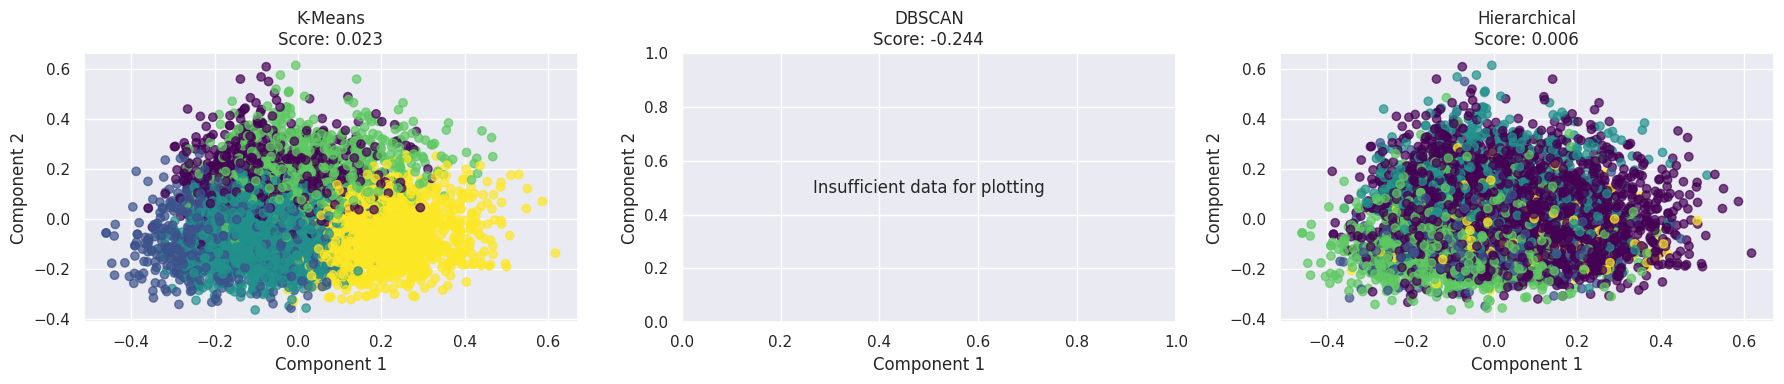

In [39]:
print("\n Creating visualization...")
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X.toarray())

plt.figure(figsize=(18, 4))
algorithms = [
    ('K-Means', kmeans_labels, best_score),
    ('DBSCAN', dbscan_labels, dbscan_score),
    ('Hierarchical', hier_labels, hier_score)
]

for i, (name, labels, score) in enumerate(algorithms):
    plt.subplot(1, 3, i+1)
    if len(set(labels)) > 1 and score > 0:
        plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='viridis', alpha=0.7)
        plt.title(f'{name}\nScore: {score:.3f}')
    else:
        plt.text(0.5, 0.5, 'Insufficient data for plotting',
                 horizontalalignment='center', verticalalignment='center',
                 transform=plt.gca().transAxes)
        plt.title(f'{name}\nScore: {score:.3f}')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')

plt.tight_layout()
plt.show()

SAVE RESULTS


In [44]:
df_clean.to_csv('final_clustered_results.csv', index=False)
print("\nResults saved to 'final_clustered_results.csv'")

print("\nANALYSIS COMPLETE")
print("SUMMARY:")
print(f"{winner} is best algorithm with score {results[winner]:.3f}")
print(f"Found {best_k} customer groups")


Results saved to 'final_clustered_results.csv'

ANALYSIS COMPLETE
SUMMARY:
K-Means is best algorithm with score 0.023
Found 5 customer groups
